### Project Topic

This project explores the application of supervised learning techniques to classify mushrooms as either **edible** or **poisonous**. This is a **binary classification problem** as the task is to predict one of two discrete classes. 

The primary goal of this project is to:
1.  Demonstrate the process of supervised learning by applying multiple machine learning algorithms to a real-world classification task.
2.  Learn and implement advanced techniques such as hyperparameter tuning, feature engineering, and model evaluation.
3.  Showcase performance metrics and comparisons to determine the most effective model for the task.
4.  Highlight the importance of accurate classification in practical scenarios, such as identifying potentially dangerous mushrooms.

### Data 

The dataset used is the **Secondary Mushroom Dataset** from the UCI Machine Learning Repository.
> Dua, D., & Graff, C. (2019). UCI Machine Learning Repository [Secondary Mushroom Dataset]. Retrieved from [https://archive.ics.uci.edu/dataset/848/secondary+mushroom+datase](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+datase).


This dataset was curated as a simulated dataset for binary classification tasks, specifically focusing on the edibility of mushrooms based on their features. It provides diverse feature types and a large number of samples, making it suitable for exploring advanced machine learning techniques and evaluating model performance comprehensively.

The data is sourced into this notebook using the `ucimlrepo` package.

#### Data Description

- **Number of Samples:** 61,068
- **Number of Features:** 20
- **Feature Types:**
  - Categorical features (e.g., cap shape, surface, color, etc.)
  - Continuous features (e.g., numerical indicators for specific measurements: cap diameter, stem height & width)
- **Task Type:** Binary classification (edible or poisonous)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ucimlrepo import fetch_ucirepo 

In [2]:
# Thanks, UCI_ML_Repo!
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
# data (as pandas dataframes) 
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 
  
# metadata 
# print(secondary_mushroom.metadata) 
# variable information 
print(secondary_mushroom.variables) 

                    name     role         type demographic description units  \
0                  class   Target  Categorical        None        None  None   
1           cap-diameter  Feature   Continuous        None        None  None   
2              cap-shape  Feature  Categorical        None        None  None   
3            cap-surface  Feature  Categorical        None        None  None   
4              cap-color  Feature  Categorical        None        None  None   
5   does-bruise-or-bleed  Feature  Categorical        None        None  None   
6        gill-attachment  Feature  Categorical        None        None  None   
7           gill-spacing  Feature  Categorical        None        None  None   
8             gill-color  Feature  Categorical        None        None  None   
9            stem-height  Feature   Continuous        None        None  None   
10            stem-width  Feature   Continuous        None        None  None   
11             stem-root  Feature  Categ

In [3]:
''' 
Exploratory Data Analysis [Part 1]

The variable information printed above shows that several features were missing values.
In order to not out right break certain my logisitic regression model or to degrade performance of my other models, 
I inspected the percentage of samples missing the particular features. I decided to remove features with more than 30% of values missing
to avoid causing collinearity among the features (e.g., associating a missing veil-type with poisonous if by chance 
many poisonous records were missing a veil-type, etc.). 
For the rest with missing values I added a new, unique value (?) to represent missing. This was a viable option because the features 
in scope were all categorical instead of continuous.
'''

missing_proportions = X.isnull().mean() * 100
missing_features = missing_proportions[missing_proportions > 0].sort_values(ascending=False)
print("Missing values (%) from source dataset:")
print(missing_features)
print('Cleaning data...', end='\n\n')

features_to_drop = missing_proportions[missing_proportions > 30].index
X_cleaned = X.drop(columns=features_to_drop)

features_to_mod = missing_proportions[missing_proportions <= 30].index
for f in features_to_mod:
    X_cleaned.fillna({ f: "?" }, inplace=True)

missing_proportions_check = X_cleaned.isnull().mean() * 100
missing_features_check = missing_proportions_check[missing_proportions_check > 0]
assert len(missing_features_check) == 0, 'Data is not cleaned as expected'
X = X_cleaned
print('Data is clean and ready to explore, train, and test!')
print(X.head())

Missing values (%) from source dataset:
veil-type            94.797688
spore-print-color    89.595376
veil-color           87.861272
stem-root            84.393064
stem-surface         62.427746
gill-spacing         41.040462
cap-surface          23.121387
gill-attachment      16.184971
ring-type             4.046243
dtype: float64
Cleaning data...

Data is clean and ready to explore, train, and test!
   cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0         15.26         x           g         o                    f   
1         16.60         x           g         o                    f   
2         14.07         x           g         o                    f   
3         14.17         f           h         e                    f   
4         14.64         x           h         o                    f   

  gill-attachment gill-color  stem-height  stem-width stem-color has-ring  \
0               e          w        16.95       17.09          w        t   
1       

In [49]:
'''
Exploratory Data Analysis [Part 2]

First, I graphed the distribution of the target class to check whether the dataset is well balanced between edible and poisonous 
samples. A balanced dataset allows me to split my test and training samples without worrying about one class dominating the other.

Next, I used a correlation matrix, boxplots, and countplots to assess whether any strong multicollinearity exists between the 
features and to evaluate the importance of each feature individually. Since the dataset is composed primarily of categorical features, 
I first encoded those feature values into numeric values. This allowed me to display a correlation matrix, which showed almost 
no significant correlations. However, this lack of correlations might be due to the nature of the label encoding applied to the 
categorical features. Because of the label encoding and the potential for feature multicollinearity, I hypothesized that my 
logistic regression model (see the "Models" section below) would perform the worst among the models I tested.

The boxplots (used for numerical features) and countplots (used for categorical features) provided more insightful observations. 
The three numerical features exhibited a similar distribution of values across each feature, with a general trend that large outliers 
were typically associated with edible samples. However, since most values overlapped between classes, I predicted that the numerical 
features would not be the most influential in the models. I reached a similar conclusion for the more balanced categorical features.

However, among the categorical features, several stood out based on their countplots as being likely to have significant predictive 
importance. Specifically, cap-surface, gill-attachment, gill-color, and stem-color appeared to be particularly important features.

'''
None #Disable cell output

In [5]:
print(type(y))
y_col = y.iloc[:, 0]
print(type(y_col))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


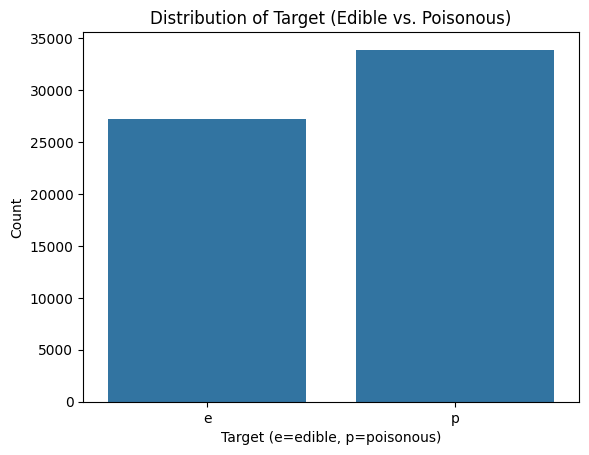

In [6]:
sns.countplot(x=y_col, order=['e', 'p'])
plt.title("Distribution of Target (Edible vs. Poisonous)")
plt.xlabel("Target (e=edible, p=poisonous)")
plt.ylabel("Count")
plt.show()

In [7]:
num_features = X.select_dtypes(include=['float64'])
cat_features = X.select_dtypes(include=['object'])
print(f'{len(num_features.columns)} numeric features')
print(f'{len(cat_features.columns)} categorical features')

3 numeric features
11 categorical features


In [8]:
from sklearn.preprocessing import LabelEncoder

def label_encode_data(data, le_map):
    clone = data.copy()
    for col in clone.select_dtypes(include=['object']):
        le = LabelEncoder()
        clone[col] = le.fit_transform(clone[col])
        le_map[col] = le
    return clone, le_map

def label_decode_data(data, le_map):
    clone = data.copy()
    for col, le in le_map.items():
        clone[col] = le.inverse_transform(clone[col])
    return clone

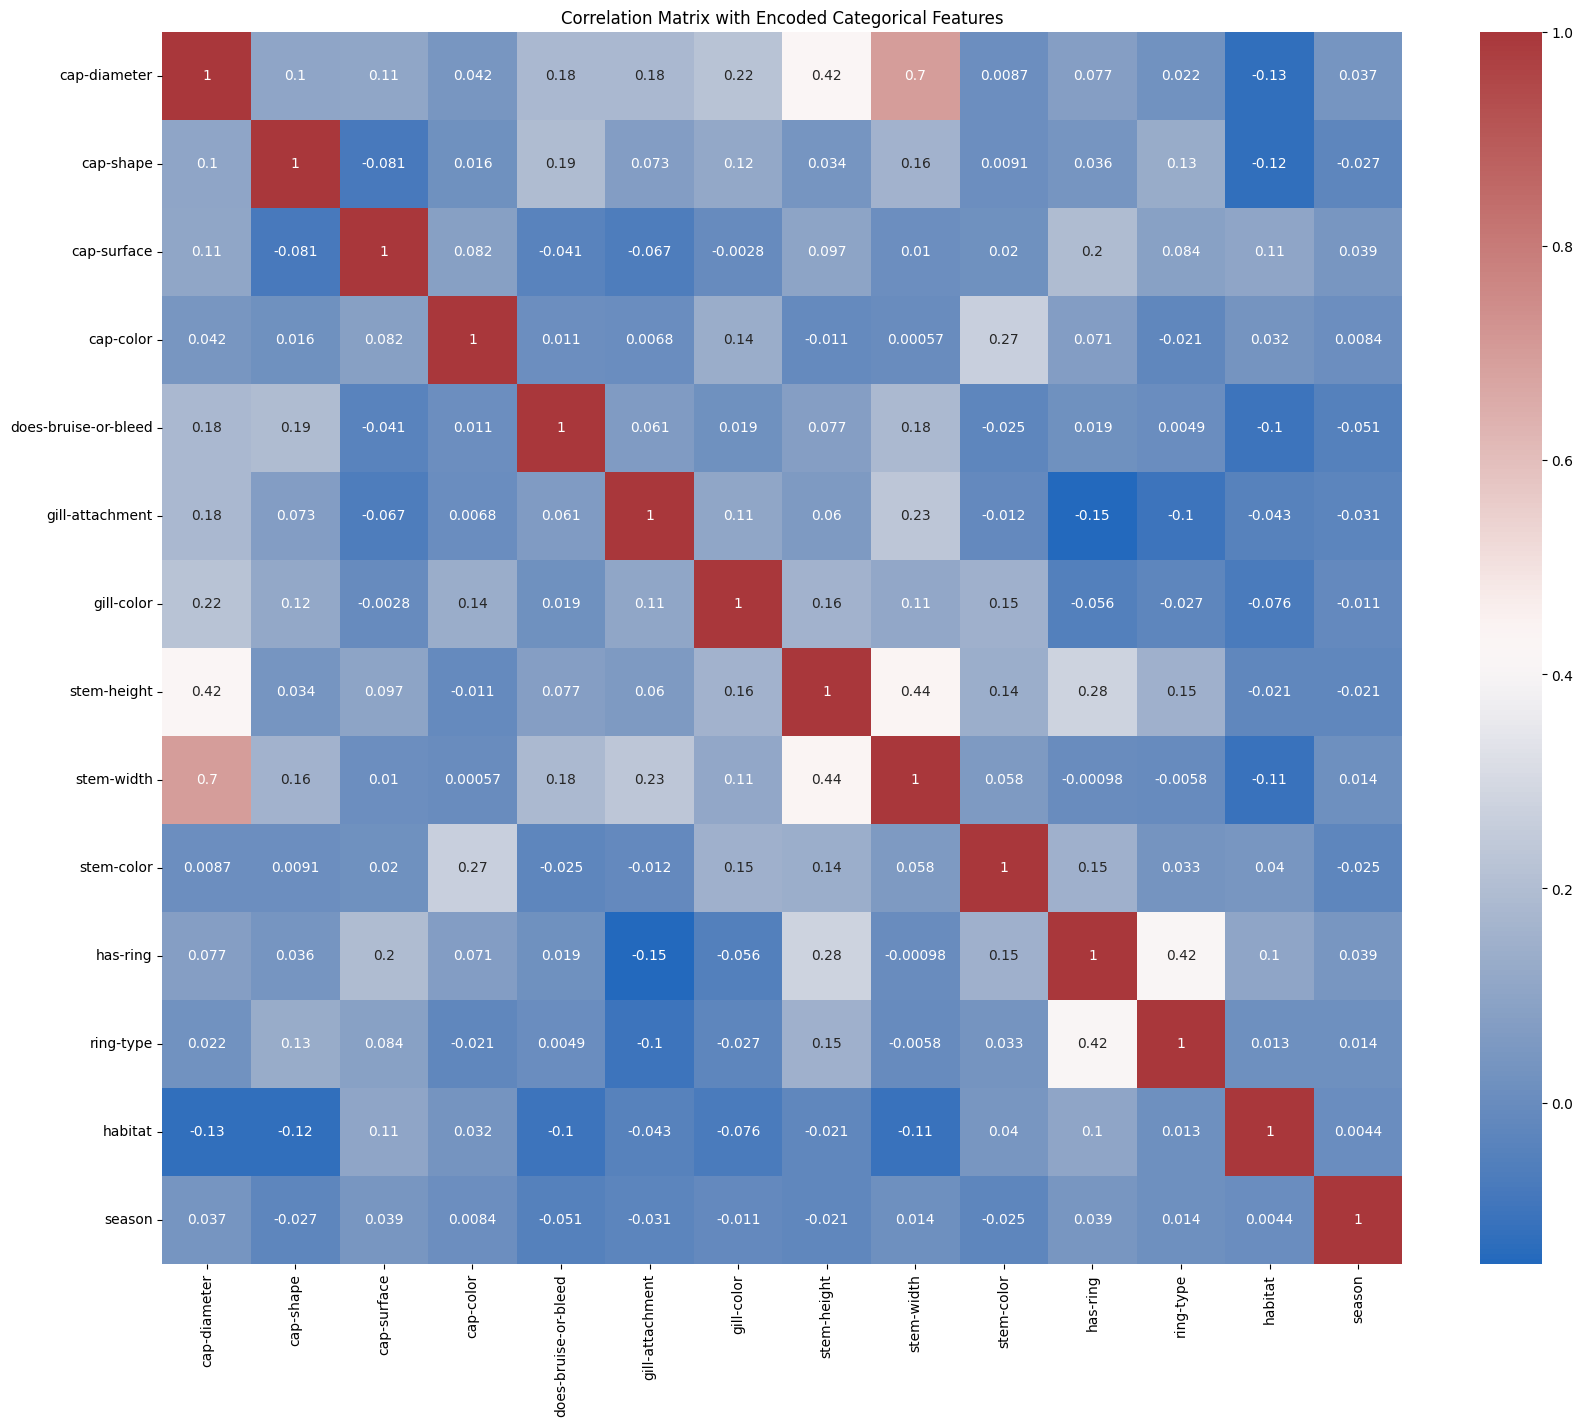

In [9]:
X_le, X_le_map = label_encode_data(X, {})
plt.figure(figsize=(20,16))
sns.heatmap(X_le.corr(), cmap='vlag', annot=True)
plt.title("Correlation Matrix with Encoded Categorical Features")
plt.show()

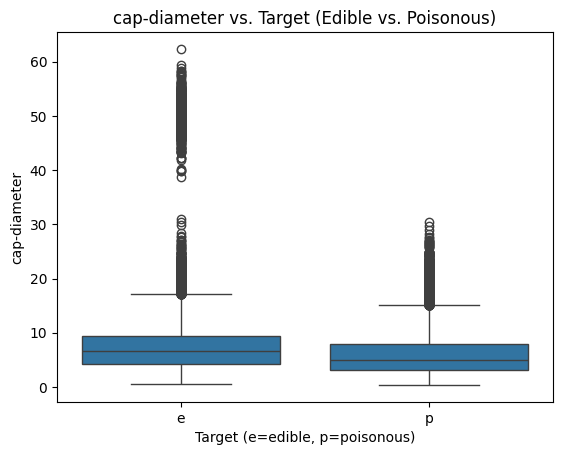

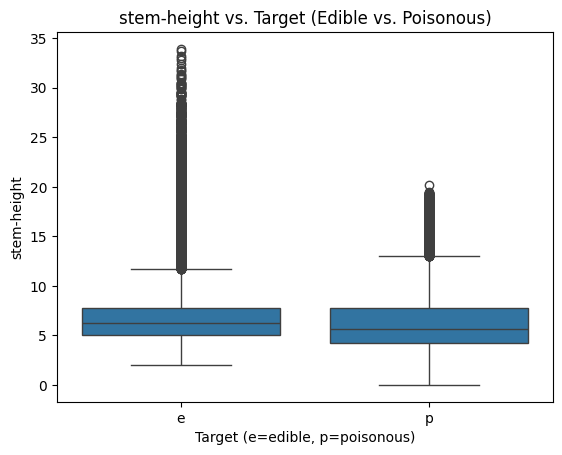

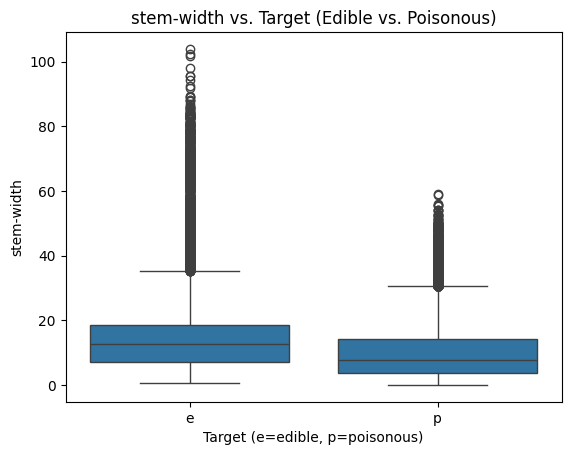

In [10]:
for f in num_features:
    sns.boxplot(x=y_col, y=f, data=X, order=['e', 'p'])
    plt.title(f + ' vs. Target (Edible vs. Poisonous)')
    plt.xlabel('Target (e=edible, p=poisonous)')
    plt.show()

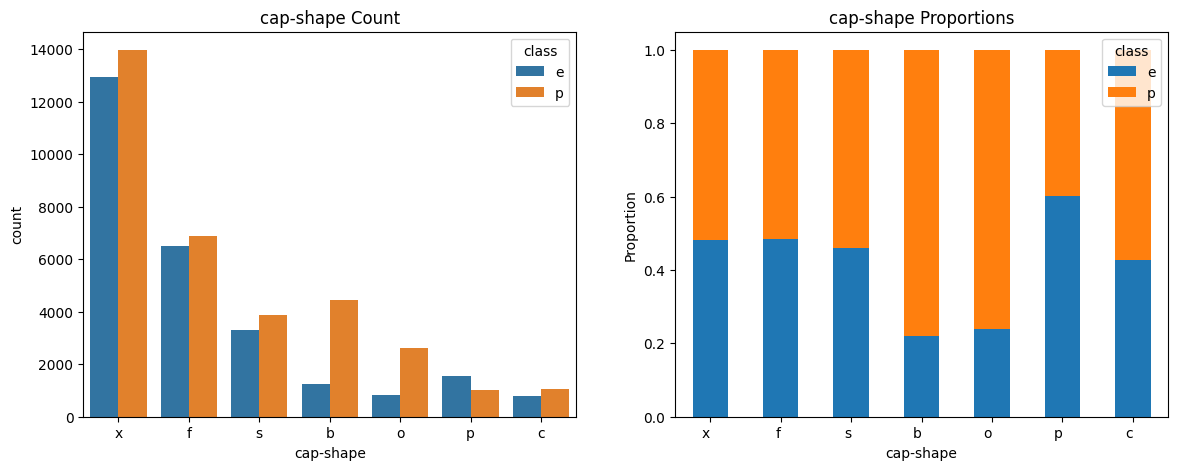

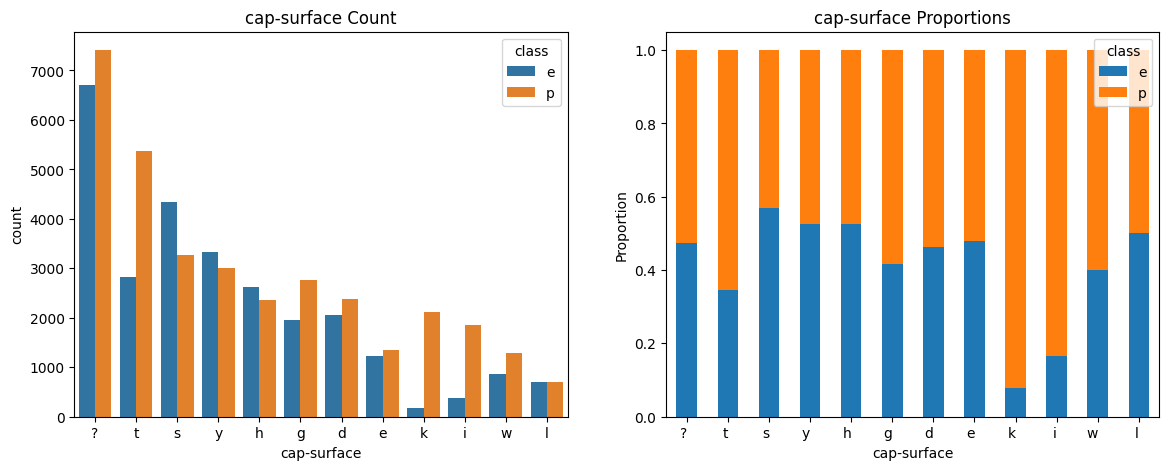

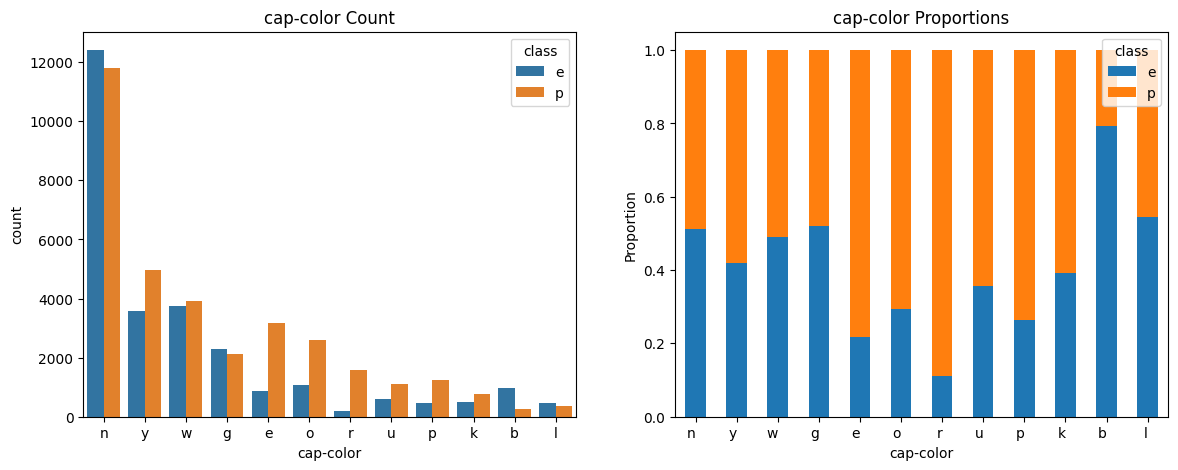

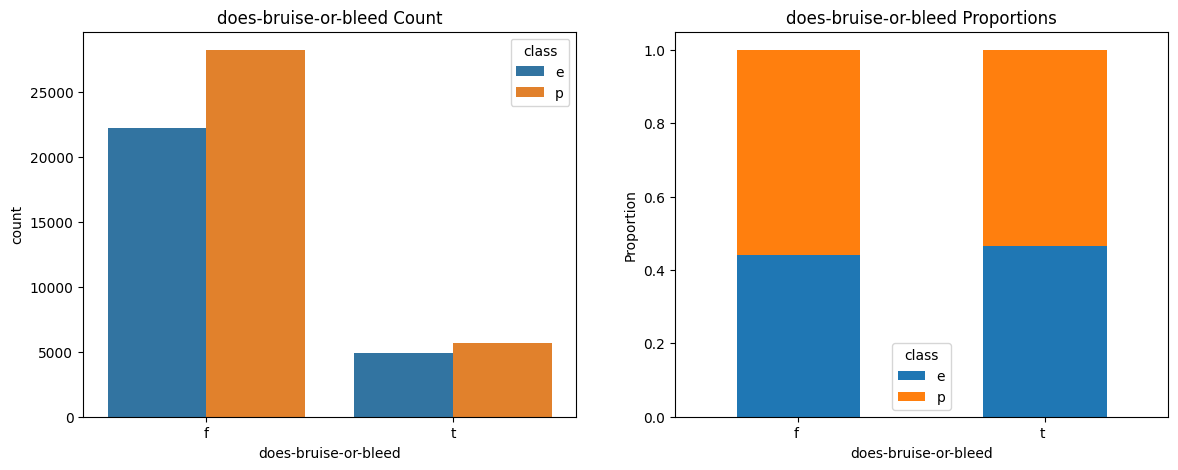

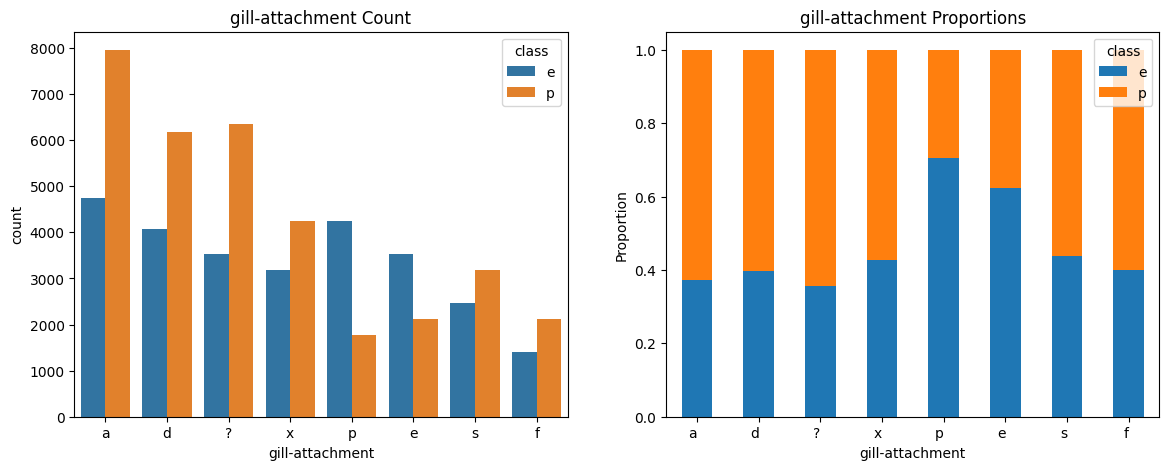

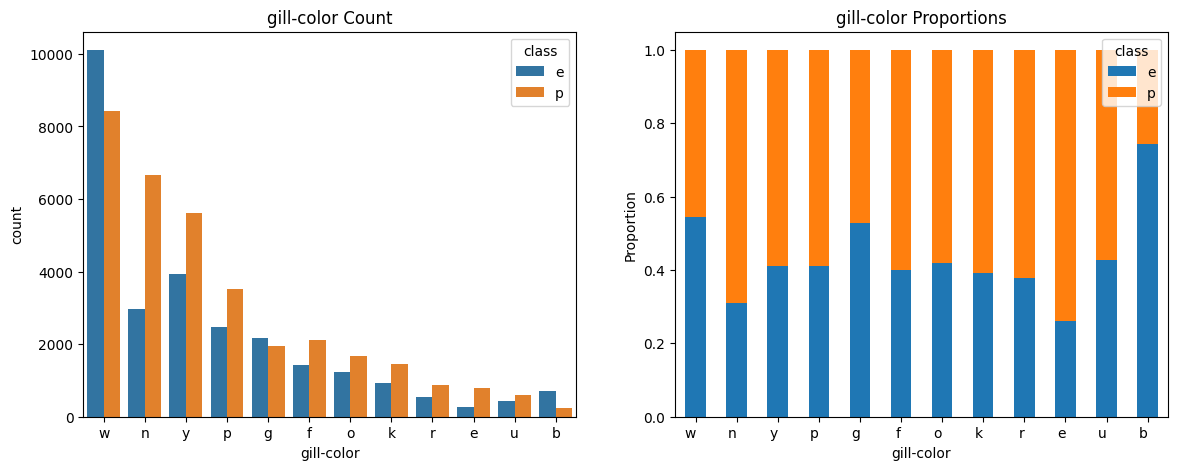

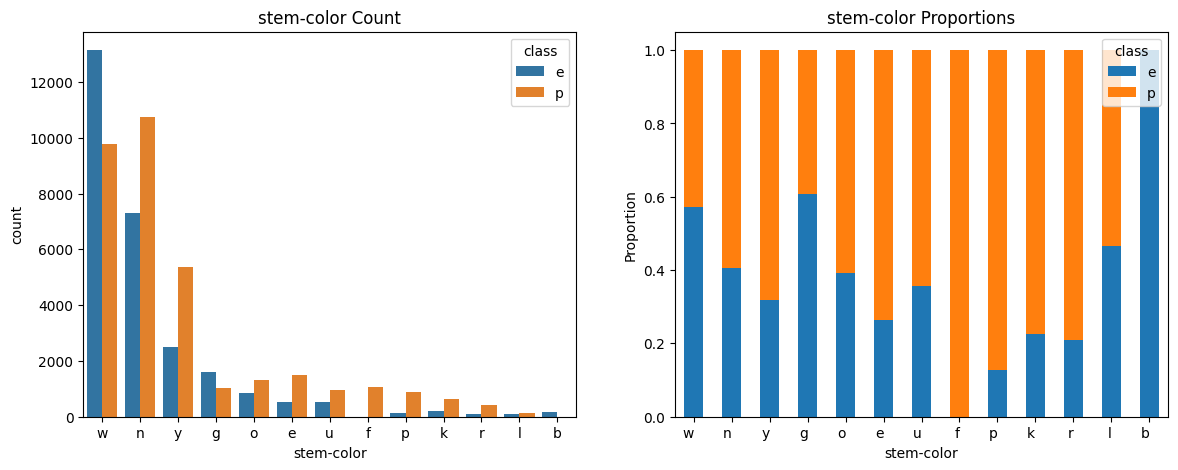

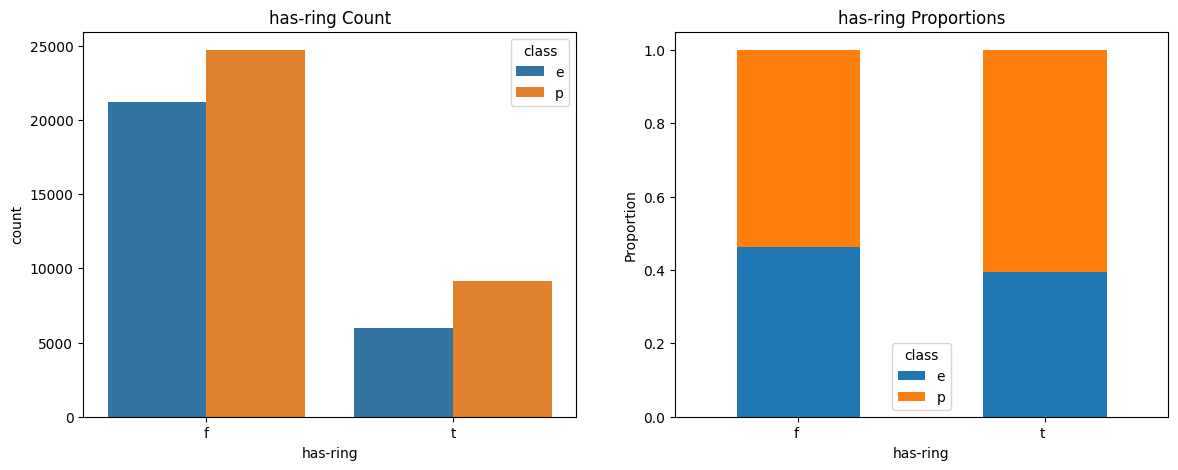

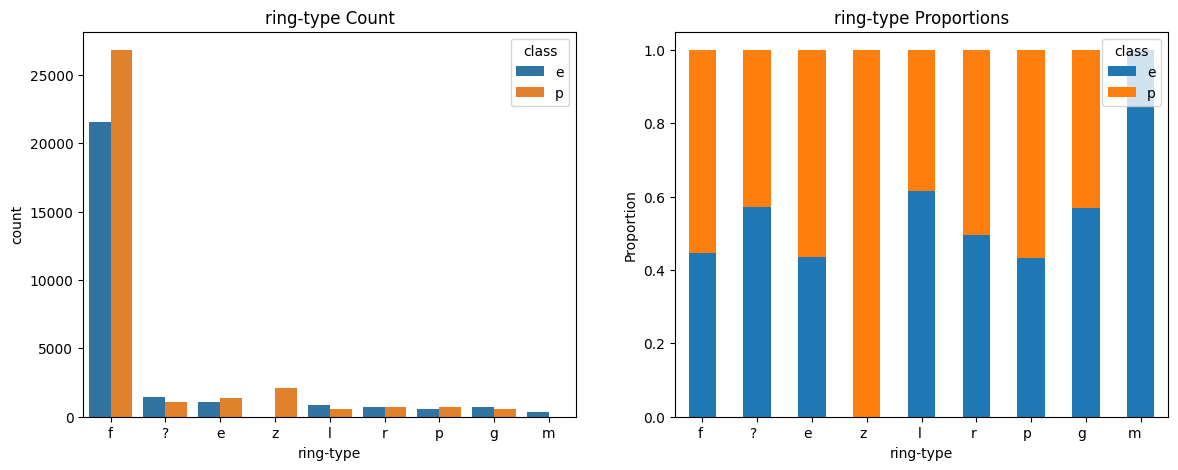

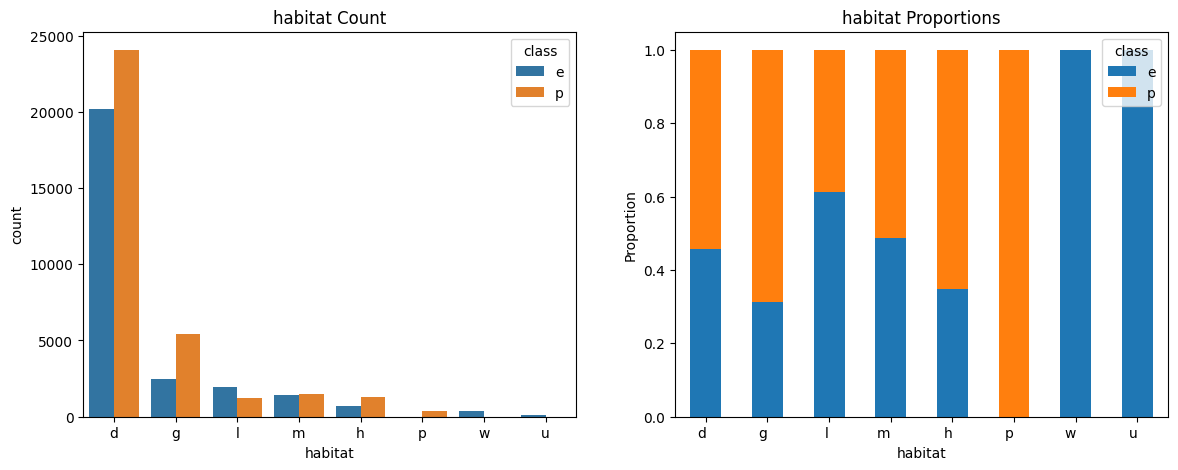

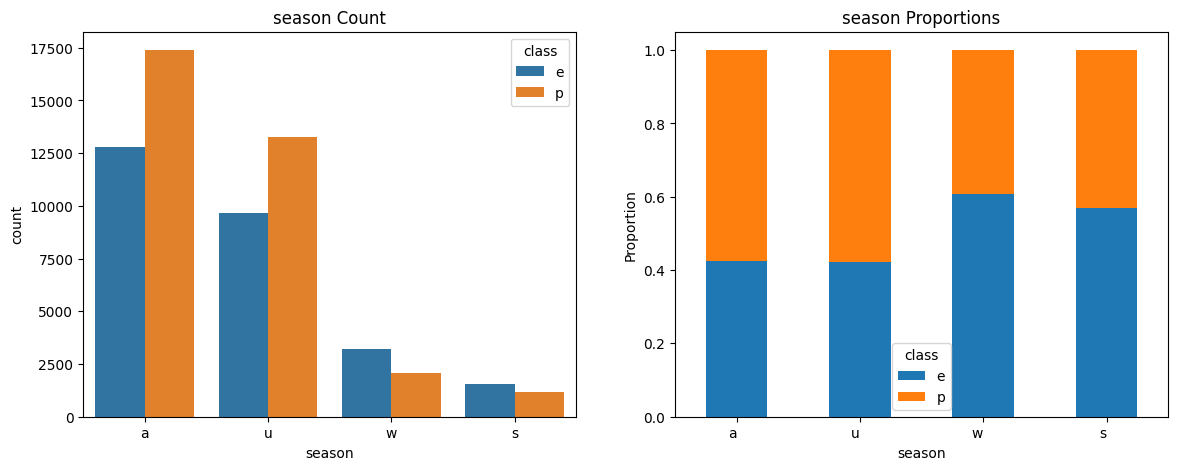

In [11]:
for f in cat_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    order = X[f].value_counts().index
    
    sns.countplot(x=f, hue=y_col, data=X, ax=axes[0], order=order, hue_order=['e', 'p'])
    axes[0].set_title(f + ' Count')
    
    proportions = X.groupby([f, y_col]).size().unstack().reindex(index=order)
    proportions.div(proportions.sum(axis=1), axis=0).plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title(f + ' Proportions')
    axes[1].set_ylabel("Proportion")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, ha='right')

    plt.show()


In [52]:
'''
Models

I chose several models to train and evaluate their performance and accuracy in classifying mushrooms as edible or poisonous. I selected 
Logistic Regression for its simplicity, though I anticipated it might struggle due to the label encoding and potential multicollinearity 
among the features.

I also selected Gradient Boosting and Random Forest because of their ability to handle non-linear relationships effectively. I wanted 
to compare their performance to observe the differences between these two models. Gradient Boosting is expected to be more 
computationally expensive due to its iterative nature, while Random Forest should train relatively quickly given the small number 
of features in this dataset.

Lastly, I chose a neural network (MLP Classifier) to experiment with a supervised learning model that was not covered in class.

'''

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import time

In [13]:
y_le, y_le_map = label_encode_data(y, {})
X_le_train, X_le_test, y_le_train, y_le_test = train_test_split(X_le, y_le, test_size=0.25, random_state=28)

In [14]:
accuracy_scores = {}
def evaluate_performance(y_pred, title=None):
    if title != None:
        print(title, end='\n\n')
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y_le_test, y_pred), display_labels=['e', 'p'])
    disp.plot()
    plt.show()

    acc = round(accuracy_score(y_le_test, y_pred),7)
    print(f'Accuracy: {acc}', end='\n')
    if (title in training_times):
        accuracy_scores[title] = acc
        print(f'Training Time: {training_times[title]}', end='\n')
    

    print("\nClassification Report:")
    print(classification_report(y_le_test, y_pred))


def evaluate_features(model, title=None):
    if title != None:
        print(title, end='\n\n')
    
    feature_importances = pd.Series(model.feature_importances_, index=X_le.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar')
    plt.title("Feature Importances")
    plt.show()

In [15]:
def hyperparameter_tuning(model, params, X_train, y_train, cv=5):
    grid_search = GridSearchCV(
        model, 
        params, 
        cv=cv, 
        scoring='accuracy', 
        n_jobs=-1
    ).fit(X_train, y_train.iloc[:, 0])
    
    print(f'Best Parameters: {grid_search.best_params_}')
    return grid_search.best_estimator_

In [16]:
training_times = {
    # model_name: elapsed time in ms
}
def log_training_time(model_name, s, e):
    training_times[model_name] = round((e - s) * 1000)

In [17]:


#Logisitc Regression


In [18]:
s = time.perf_counter()
lr_model = LogisticRegression(n_jobs=-1).fit(X_le_train, y_le_train.iloc[:, 0])
log_training_time('Logistic Regression', s, time.perf_counter())

Logistic Regression



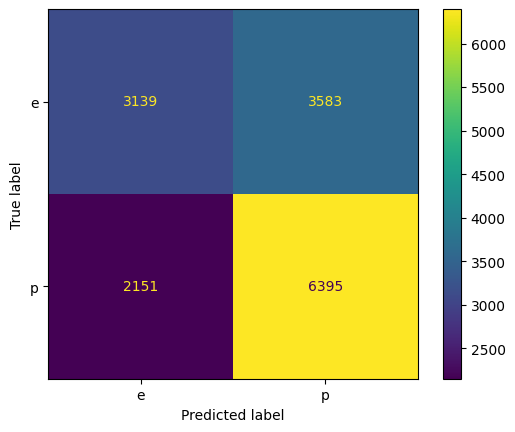

Accuracy: 0.6244433
Training Time: 1634

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.47      0.52      6722
           1       0.64      0.75      0.69      8546

    accuracy                           0.62     15268
   macro avg       0.62      0.61      0.61     15268
weighted avg       0.62      0.62      0.62     15268

Coefficients:
[[-0.04716796 -0.11097769  0.00660107  0.03805657  0.15151233 -0.03516807
   0.00681629 -0.03822812 -0.01789552 -0.07154598  0.32622107  0.15393449
  -0.14328419 -0.11674118]]


In [19]:
lr_pred = lr_model.predict(X_le_test)
evaluate_performance(lr_pred, 'Logistic Regression')

print('Coefficients:')
print(lr_model.coef_)

In [20]:
lr_params = {
    'C': [0.1, 0.5, 1, 2, 5, 10],
    'class_weight': [None, {1: 2, 0: 1}],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [100, 250, 500],
    'n_jobs': [-1]
}
tuned_lr_model = hyperparameter_tuning(
    LogisticRegression(n_jobs=-1),
    lr_params,
    X_le_train,
    y_le_train
)

Best Parameters: {'C': 5, 'class_weight': None, 'max_iter': 100, 'n_jobs': -1, 'solver': 'lbfgs'}


Hyperparameter Tuned Logistic Regression



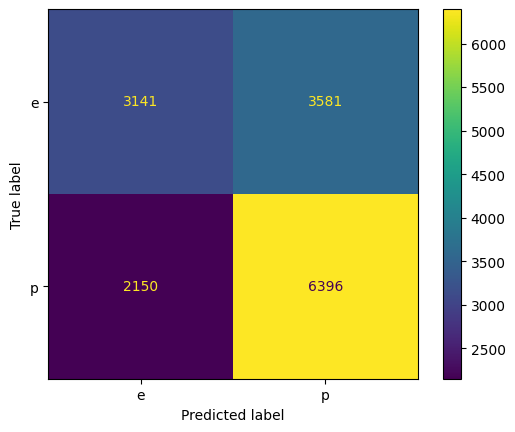

Accuracy: 0.6246398

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.47      0.52      6722
           1       0.64      0.75      0.69      8546

    accuracy                           0.62     15268
   macro avg       0.62      0.61      0.61     15268
weighted avg       0.62      0.62      0.62     15268

Coefficients:
[[-0.04716796 -0.11097769  0.00660107  0.03805657  0.15151233 -0.03516807
   0.00681629 -0.03822812 -0.01789552 -0.07154598  0.32622107  0.15393449
  -0.14328419 -0.11674118]]


In [21]:
tuned_lr_pred = tuned_lr_model.predict(X_le_test)
evaluate_performance(tuned_lr_pred, 'Hyperparameter Tuned Logistic Regression')

print('Coefficients:')
print(lr_model.coef_)

In [22]:
def one_hot_encode_data(data):
    clone = data.copy()
    oh_map = {}
    for col in clone.select_dtypes(include=['object']):
        oh_encoded = pd.get_dummies(clone[col], prefix=col)
        oh_map[col] = oh_encoded.columns.tolist()
        clone = clone.drop(columns=[col]).join(oh_encoded)
    return clone, oh_map

def oh_decode_data(data, oh_map):
    clone = data.copy()
    for original_col, oh_cols in oh_map.items():
        oh_data = clone[oh_cols]
        clone[original_col] = oh_data.idxmax(axis=1).str[len(original_col) + 1:]  # Remove the prefix
        clone = clone.drop(columns=oh_cols)
    return clone

In [23]:
X_oh, X_oh_map = one_hot_encode_data(X)
X_oh_train, X_oh_test, y_le_train, y_le_test = train_test_split(X_oh, y_le, test_size=0.25, random_state=28)

In [24]:
print(X_oh.head())

   cap-diameter  stem-height  stem-width  cap-shape_b  cap-shape_c  \
0         15.26        16.95       17.09        False        False   
1         16.60        17.99       18.19        False        False   
2         14.07        17.80       17.74        False        False   
3         14.17        15.77       15.98        False        False   
4         14.64        16.53       17.20        False        False   

   cap-shape_f  cap-shape_o  cap-shape_p  cap-shape_s  cap-shape_x  ...  \
0        False        False        False        False         True  ...   
1        False        False        False        False         True  ...   
2        False        False        False        False         True  ...   
3         True        False        False        False        False  ...   
4        False        False        False        False         True  ...   

   habitat_h  habitat_l  habitat_m  habitat_p  habitat_u  habitat_w  season_a  \
0      False      False      False      False  

In [25]:
s = time.perf_counter()
lr_model = LogisticRegression(n_jobs=-1).fit(X_oh_train, y_le_train.iloc[:, 0])
log_training_time('Logistic Regression (One-Hot)', s, time.perf_counter())

Logistic Regression (One-Hot)



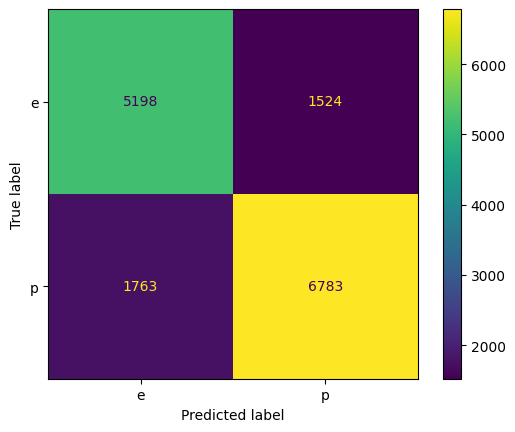

Accuracy: 0.7847131
Training Time: 884

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      6722
           1       0.82      0.79      0.80      8546

    accuracy                           0.78     15268
   macro avg       0.78      0.78      0.78     15268
weighted avg       0.79      0.78      0.79     15268

Coefficients:
[[-0.05541257  0.10342152 -0.00478196  1.10832176 -0.26035395 -0.39931733
   0.92464971 -0.29396218 -0.76132402 -0.34600821 -0.15917259  0.01317117
   0.7765774  -0.71520952 -0.9459746   1.51887443  3.12490924 -1.50653604
  -0.87449425 -0.04587881 -0.64723163 -0.56702903 -1.52046828  1.03537539
  -0.395653    0.55215264 -1.53578626 -0.62082615  0.68651553  0.13585475
   1.89031149  0.42652953 -0.28953125 -0.39246861  0.03396843 -0.06196265
   0.30403035  0.40740371  0.99547299 -0.48721207  0.06458342 -2.22051891
   0.37093656  0.53730973 -1.84648657  1.12022589  0.06458342 -0.19493094
   0

In [28]:
lr_pred = lr_model.predict(X_oh_test)
evaluate_performance(lr_pred, 'Logistic Regression (One-Hot)')

print('Coefficients:')
print(lr_model.coef_)

In [29]:


#Gradient Boosting


In [30]:
s = time.perf_counter()
gb_model = GradientBoostingClassifier().fit(X_le_train, y_le_train.iloc[:, 0])
log_training_time('Gradient Boosting', s, time.perf_counter())

Gradient Boosting



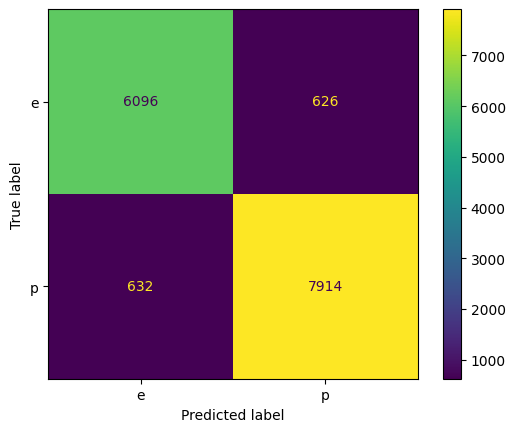

Accuracy: 0.9176054
Training Time: 4724

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6722
           1       0.93      0.93      0.93      8546

    accuracy                           0.92     15268
   macro avg       0.92      0.92      0.92     15268
weighted avg       0.92      0.92      0.92     15268



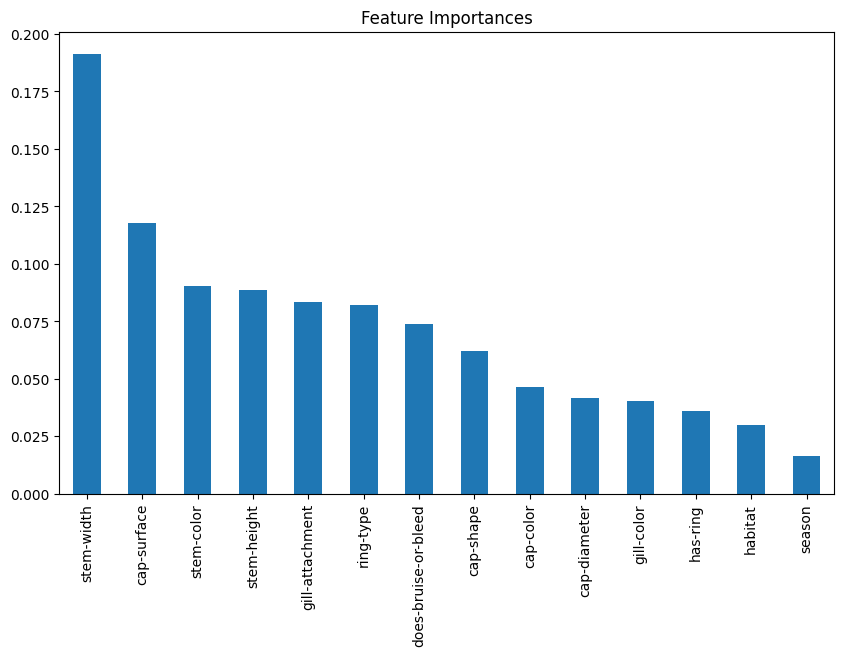

In [31]:
gb_pred = gb_model.predict(X_le_test)
evaluate_performance(gb_pred, 'Gradient Boosting')
evaluate_features(gb_model)

In [33]:
gb_params = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.05, 0.1, 0.2],
    # 'n_estimators': [50, 100, 200],
    'n_estimators': [200, 300],
    # 'max_depth': [3, 5, 7],
    'max_depth': [7, 10],
    # 'min_samples_leaf': [1, 2],
    # 'max_features': ['sqrt', None],
    'max_features': ['sqrt', 'log2'],
}

X_le_train_tune, X_le_test_tune, y_le_train_tune, y_le_test_tune = train_test_split(X_le, y_le, test_size=0.99)

hyperparameter_tuning(
    GradientBoostingClassifier(),
    gb_params,
    X_le_train_tune,
    y_le_train_tune
)

Best Parameters: {'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 300}


GradientBoostingClassifier(learning_rate=0.2, max_depth=7, max_features='log2',
                           n_estimators=300)

Gradient Boosting (Hyperparameter Tuned)



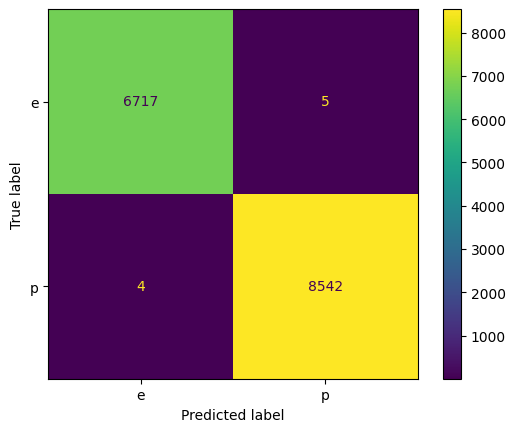

Accuracy: 0.9994105
Training Time: 12281

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6722
           1       1.00      1.00      1.00      8546

    accuracy                           1.00     15268
   macro avg       1.00      1.00      1.00     15268
weighted avg       1.00      1.00      1.00     15268



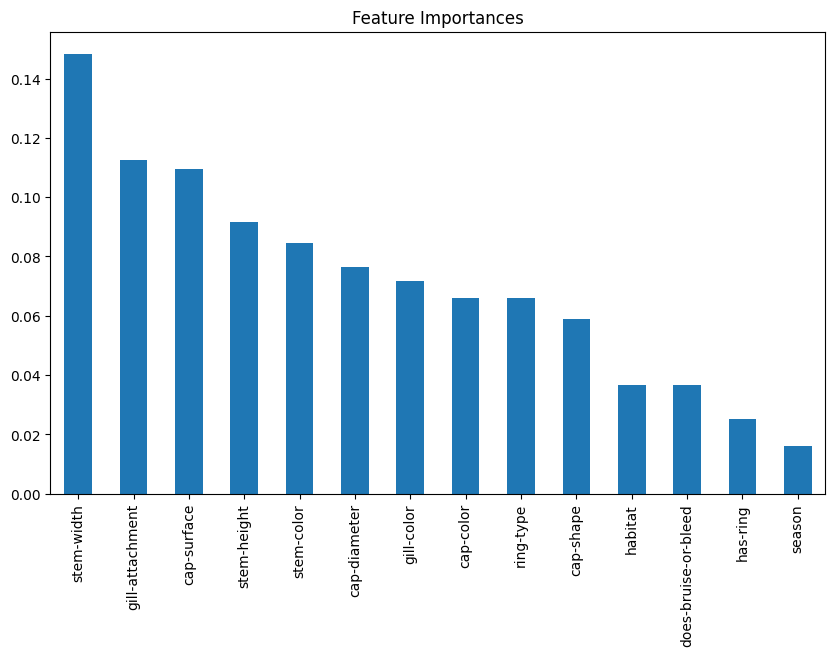

In [34]:
'''
Best Parameters: {
    'learning_rate': 0.1, 
    'loss': 'exponential',
    'max_depth': 7, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 1, 
    'n_estimators': 200
}
'''

s = time.perf_counter()
tuned_gb_model_1 = GradientBoostingClassifier(
    learning_rate=0.1,
    loss='exponential',
    max_depth=7,
    max_features='sqrt',
    min_samples_leaf=1,
    n_estimators=200
).fit(X_le_train, y_le_train.iloc[:, 0])
log_training_time('Gradient Boosting (Hyperparameter Tuned)', s, time.perf_counter())

tuned_gb_pred = tuned_gb_model_1.predict(X_le_test)
evaluate_performance(tuned_gb_pred, 'Gradient Boosting (Hyperparameter Tuned)')
evaluate_features(tuned_gb_model_1)

Hyparameter Tuned Gradient Boosting Classifier (2)



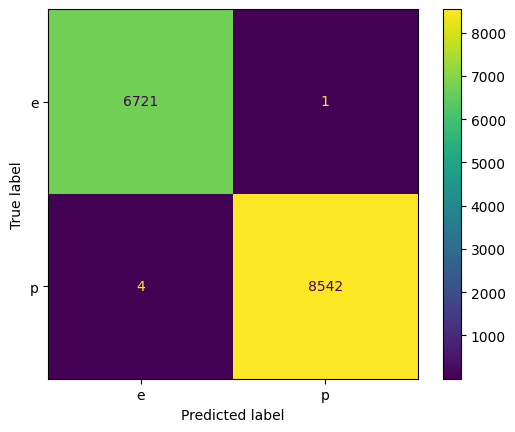

Accuracy: 0.9996725176840451

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6722
           1       1.00      1.00      1.00      8546

    accuracy                           1.00     15268
   macro avg       1.00      1.00      1.00     15268
weighted avg       1.00      1.00      1.00     15268



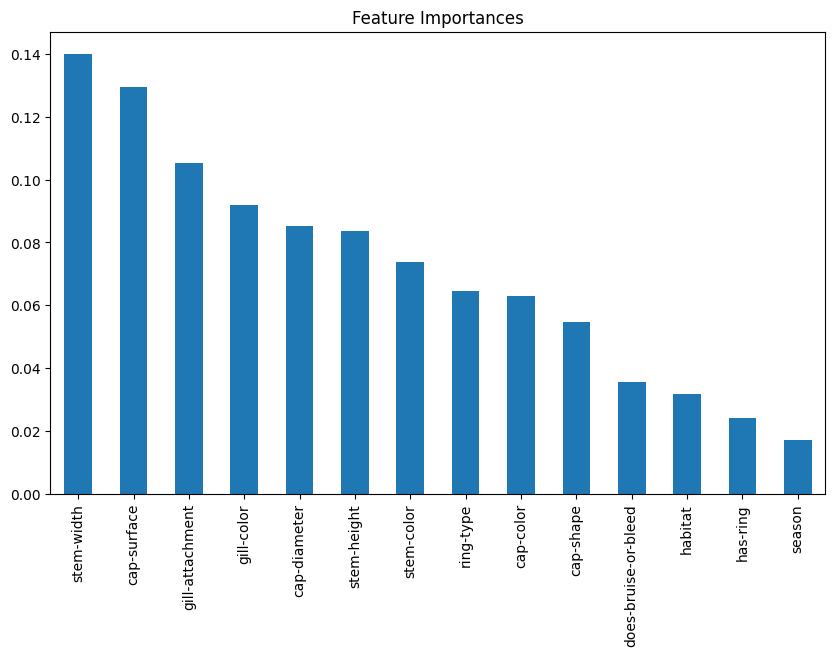

In [39]:
'''
Best Parameters: {
    'learning_rate': 0.2, 
    'loss': 'log_loss', 
    'max_depth': 7, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 1, 
    'n_estimators': 200
}
'''

tuned_gb_model_2 = GradientBoostingClassifier(
    learning_rate=0.2,
    loss='log_loss',
    max_depth=7,
    max_features='sqrt',
    min_samples_leaf=1,
    n_estimators=200
).fit(X_le_train, y_le_train.iloc[:, 0])
tuned_gb_pred = tuned_gb_model_2.predict(X_le_test)
evaluate_performance(tuned_gb_pred, 'Gradient Boosting (Hyperparameter Tuned) (2)')
evaluate_features(tuned_gb_model_2)

Hyparameter Tuned Gradient Boosting Classifier (3)



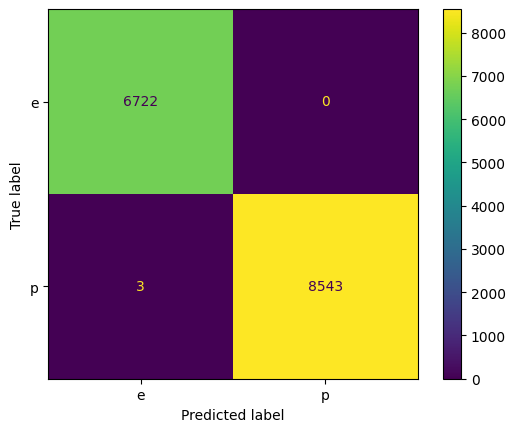

Accuracy: 0.999803510610427

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6722
           1       1.00      1.00      1.00      8546

    accuracy                           1.00     15268
   macro avg       1.00      1.00      1.00     15268
weighted avg       1.00      1.00      1.00     15268



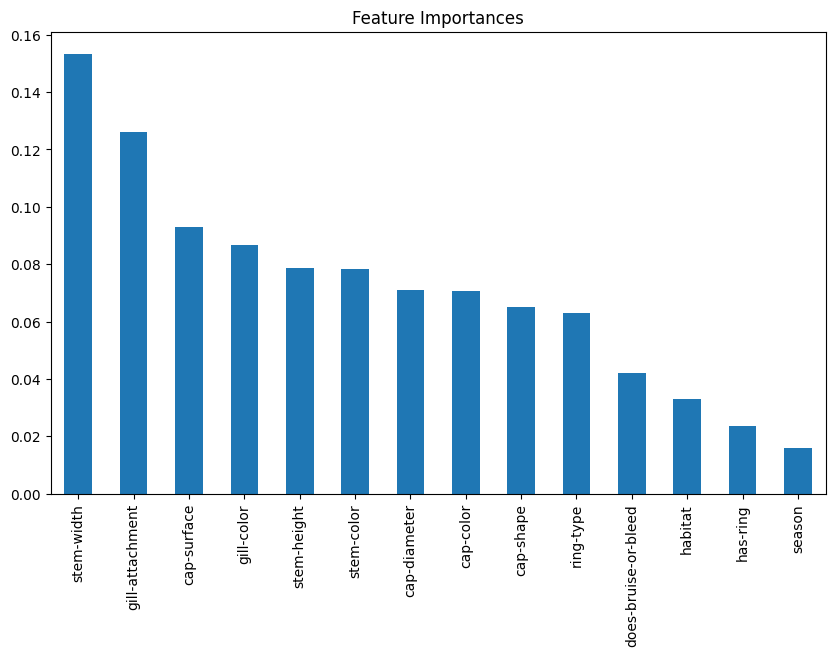

In [45]:
'''
Best Parameters: {
    'learning_rate': 0.1, 
    'loss': 'exponential', 
    'max_depth': 10, 
    'max_features': 'log2', 
    'n_estimators': 300
}
'''

tuned_gb_model_3 = GradientBoostingClassifier(
    learning_rate=0.1,
    loss='exponential',
    max_depth=10,
    max_features='log2',
    min_samples_leaf=1,
    n_estimators=300
).fit(X_le_train, y_le_train.iloc[:, 0])
tuned_gb_pred = tuned_gb_model_3.predict(X_le_test)
evaluate_performance(tuned_gb_pred, 'Gradient Boosting (Hyperparameter Tuned) (3)')
evaluate_features(tuned_gb_model_3)

In [35]:


#Random Forest


In [36]:
s = time.perf_counter()
rf_model = RandomForestClassifier(n_jobs=-1).fit(X_le_train, y_le_train.iloc[:, 0])
log_training_time('Random Forest', s, time.perf_counter())

Random Forest



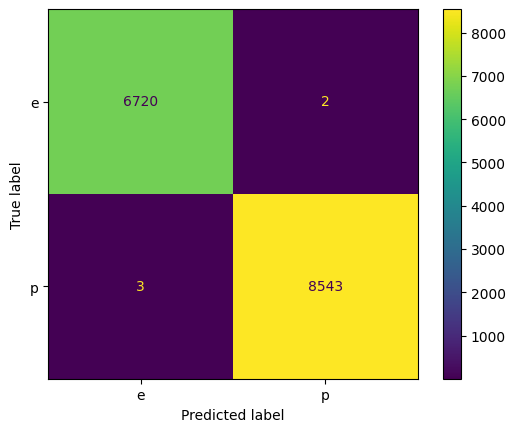

Accuracy: 0.9996725
Training Time: 778

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6722
           1       1.00      1.00      1.00      8546

    accuracy                           1.00     15268
   macro avg       1.00      1.00      1.00     15268
weighted avg       1.00      1.00      1.00     15268



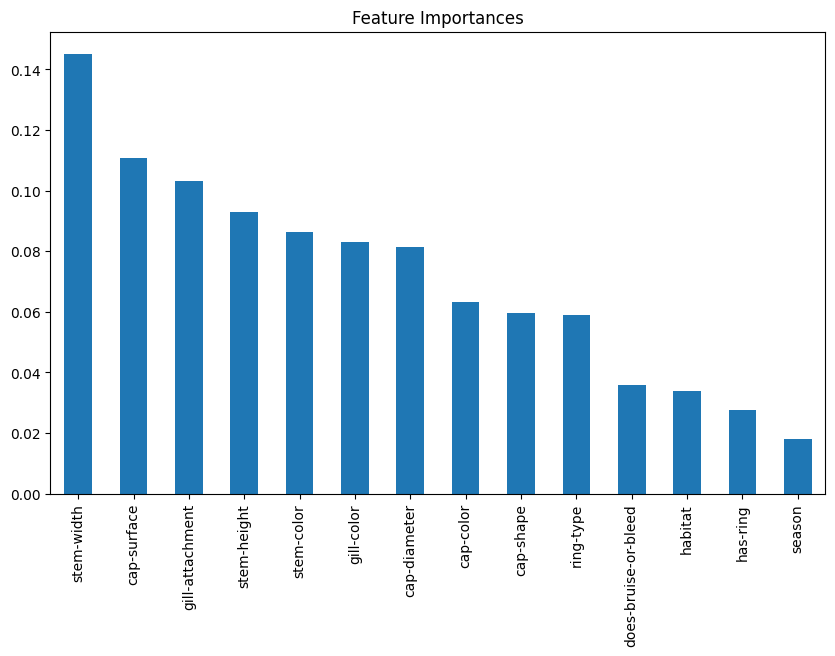

In [37]:
rf_pred = rf_model.predict(X_le_test)
evaluate_performance(rf_pred, 'Random Forest')
evaluate_features(rf_model)

In [38]:


#MLPClassifier (Neural Network)
# (not covered in class)


In [39]:
s = time.perf_counter()
mlp_model = MLPClassifier().fit(X_le_train, y_le_train.iloc[:, 0])
log_training_time('MLP Classifier', s, time.perf_counter())

MLP Classifier



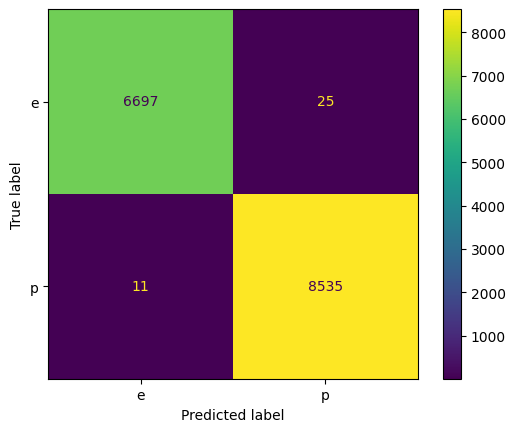

Accuracy: 0.9976421
Training Time: 23316

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6722
           1       1.00      1.00      1.00      8546

    accuracy                           1.00     15268
   macro avg       1.00      1.00      1.00     15268
weighted avg       1.00      1.00      1.00     15268



In [40]:
mlp_pred = mlp_model.predict(X_le_test)
evaluate_performance(mlp_pred, 'MLP Classifier')

In [55]:
'''
Results and Analysis

For the task of classifying mushrooms as edible versus poisonous, the consequences of labeling a poisonous mushroom as edible are 
potentially deadly. Therefore, a high precision score is crucial for minimizing false positives, i.e., labeling a poisonous mushroom as 
edible. Mislabeling edible mushrooms as poisonous is not nearly as consequential. However, for the sake of developing a good model, I 
aimed to achieve a high recall score as well, and ultimately a high F1-score since it is derived from both precision and recall.

Generally, the models performed with such high precision, recall, and F1-scores that there wasn't enough granularity to distinguish 
between them meaningfully. For my model comparisons, I plotted two graphs: one showing the accuracy scores and the other illustrating 
the training times of the models.

Three models attained near-perfect accuracy scores: the hyperparameter-tuned gradient boosting classifier, the random forest classifier, 
and the MLP classifier. However, the random forest classifier was exceptionally faster to train and did not require any advanced 
training techniques to achieve such a high accuracy score.

'''
None #Disable cell output

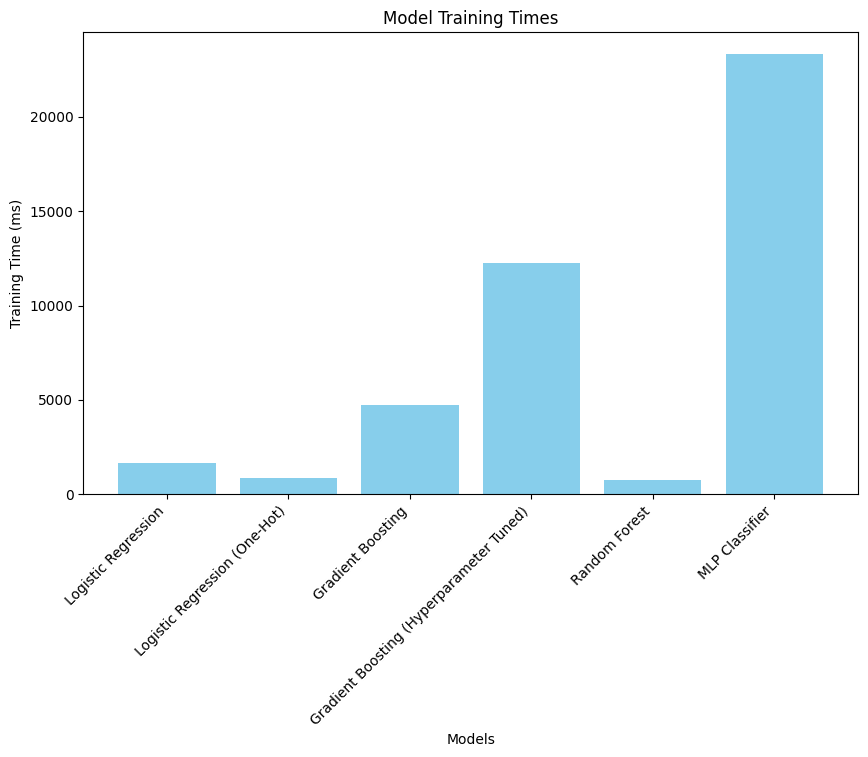

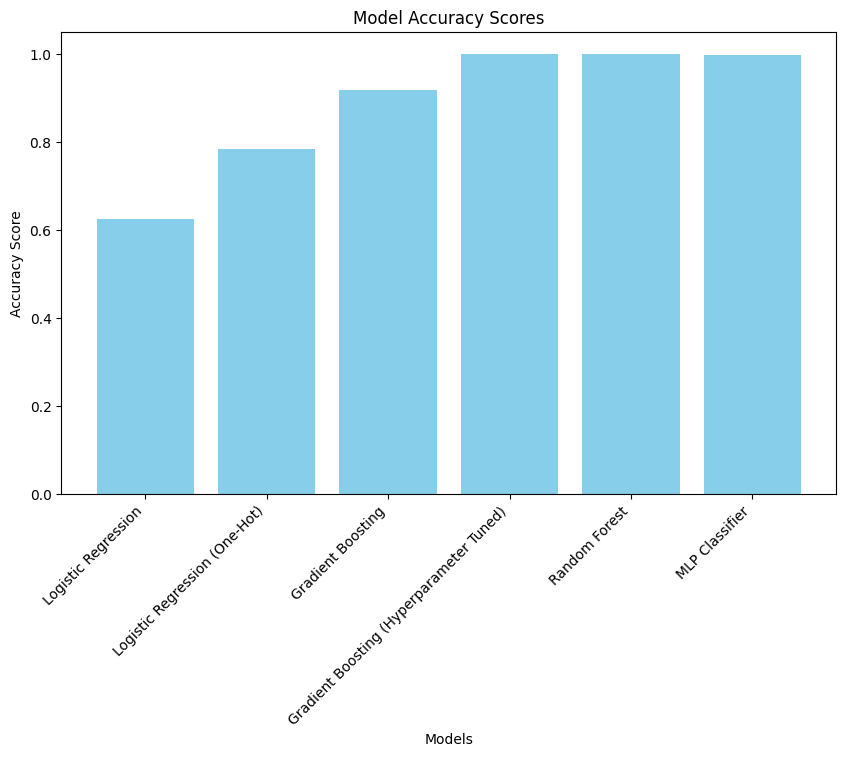

In [56]:
models = list(training_times.keys())
times = list(training_times.values())

plt.figure(figsize=(10, 6))
plt.bar(models, times, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Training Time (ms)")
plt.title("Model Training Times")
plt.xticks(rotation=45, ha="right")
plt.show()

models = list(accuracy_scores.keys())
times = list(accuracy_scores.values())

plt.figure(figsize=(10, 6))
plt.bar(models, times, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Model Accuracy Scores")
plt.xticks(rotation=45, ha="right")
plt.show()